In [14]:
# Import libraries and set desired options
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set()

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Read the training and test data sets, change paths if needed
times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv('data/train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('data/test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [5]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [6]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [7]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [9]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [10]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [11]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [12]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

In [13]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

## Функции, помогающие вытащить фичи

## Добавлениие фич


In [18]:
full_new_feat['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour)

In [19]:
full_new_feat['morning'] = full_df['time1'].apply(lambda ts: 1 if (0 < ts.hour < 12) else 0)

In [25]:
full_new_feat['part_of_the_day'] = full_df['time1'].apply(lambda ts: 1 if 0 <= ts.hour < 6 \
                                                         else 2 if 6 <= ts.hour < 12 \
                                                         else 3 if 12 <= ts.hour < 18 \
                                                         else 4)

In [26]:
full_new_feat['day_of_week'] = full_df['time1'].apply(lambda ts: ts.dayofweek)

In [27]:
full_new_feat['is_weekend'] = full_new_feat['day_of_week'].apply(lambda x: 1 if 5<= x <= 6 else 0)

In [28]:
full_new_feat['first_site'] = full_df['site1']

In [29]:
full_new_feat['second_site'] = full_df['site2'].apply(lambda site: site)

In [30]:
full_new_feat['last_site'] = full_df[sites].replace({0: np.nan}).ffill(axis=1).iloc[:, -1] 

In [37]:
top_sites_alice = pd.Series(train_df[train_df['target']==1][sites].values.flatten()
                           ).value_counts().sort_values(ascending=False)

In [48]:
total_site = top_sites_alice.values.sum()
for i in range(1, 300):
    percentage = top_sites_alice.iloc[:i].values.sum() / total_site
    print('top{} is {}%'.format(i, percentage))

top1 is 0.06016543317370483%
top2 is 0.11911188506747931%
top3 is 0.1760121898127993%
top4 is 0.21506312581628212%
top5 is 0.252372659991293%
top6 is 0.278885502829778%
top7 is 0.3016107966913365%
top8 is 0.3243360905528951%
top9 is 0.343970396168916%
top10 is 0.3634305616020897%
top11 is 0.38245537657814543%
top12 is 0.39904222899434044%
top13 is 0.4151937309534175%
top14 is 0.4279494993469743%
top15 is 0.44061819764910753%
top16 is 0.45306922072268174%
top17 is 0.46499782324771444%
top18 is 0.47683935568132346%
top19 is 0.4871136264693078%
top20 is 0.4964736612973444%
top21 is 0.5055724858511101%
top22 is 0.5145407052677405%
top23 is 0.5234218545929473%
top24 is 0.5321723987810187%
top25 is 0.5403569873748367%
top26 is 0.5472790596430126%
top27 is 0.5540269917283414%
top28 is 0.5606878537222464%
top29 is 0.5672616456247279%
top30 is 0.5737919024814976%
top31 is 0.5803221593382673%
top32 is 0.5865476708750544%
top33 is 0.5921636917718763%
top34 is 0.5976491075315629%
top35 is 0.603090

In [49]:
top279 = top_sites_alice.index[:279]

In [52]:
full_new_feat['is_in_top279'] = full_df[sites].apply(lambda sites: 1 if set(sites.values) & set(top279) else 0, axis=1)

In [53]:
full_new_feat.head()

,start_month,start_hour,morning,part_of_the_day,day_of_week,is_weekend,first_site,second_site,last_site,is_in_top279
session_id,,,,,,,,,,
21669,201301.0,8,1,2,5,1,56,55,55.0,1
54843,201301.0,8,1,2,5,1,56,55,55.0,1
77292,201301.0,8,1,2,5,1,946,946,946.0,0
114021,201301.0,8,1,2,5,1,945,948,946.0,0
146670,201301.0,8,1,2,5,1,947,950,947.0,0


## Фича селекшин

In [58]:
what_feat = full_new_feat.columns

In [59]:
what_feat

Index(['start_month', 'start_hour', 'morning', 'part_of_the_day',
       'day_of_week', 'is_weekend', 'first_site', 'second_site', 'last_site',
       'is_in_top279'],
      dtype='object')

## Тест на скор

In [61]:
# Compose the training set
tmp_scaled = StandardScaler().fit_transform(full_new_feat[what_feat])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))

# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.9711659577602907


## Окончательная отправка

In [62]:
# List of possible C-values
Cs = np.logspace(-3, 1, 10)
scores = []
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████| 10/10 [00:44<00:00,  8.21s/it]


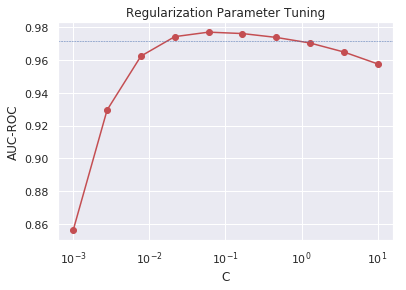

In [63]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
# horizontal line -- model quality with default C value
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed') 
plt.show()

In [64]:
C = Cs[np.argmax(scores)]
np.max(scores)

0.9767502560275156

In [65]:
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat[what_feat])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'baseline_12.csv')